# BBC News Classification

The goal for this project is correctly classify unseen news articles into the right category

The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

In [698]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [699]:
train= pd.read_csv("BBC News Train.csv")
test=pd.read_csv("BBC News Test.csv")

## Exploratory Data Analysis

In [700]:
print(train.head())
print(train.shape)

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
(1490, 3)


In [701]:
np.unique(train['Category'])

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Text(0.5, 1.0, 'Article Distribution by Category')

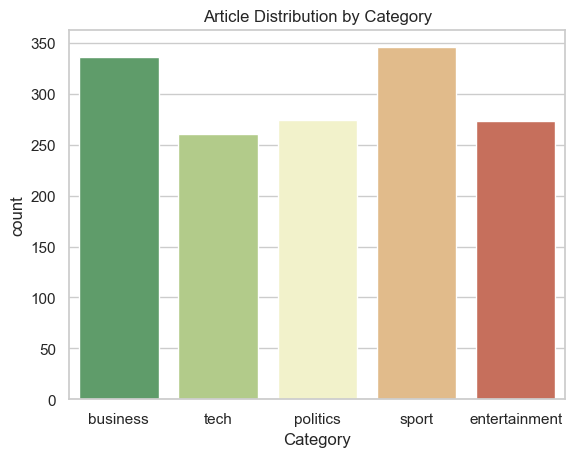

In [702]:
sns.set_theme(style="whitegrid")
sns.countplot(data=train, x='Category', palette='RdYlGn_r', saturation=0.6)
plt.title("Article Distribution by Category")

The article distribution by category is somewhat balanced, this is important as the training model with have relatively equal amount of dataset from each category and can result in higher accuracy.

Text(0.5, 1.0, 'Word count per article')

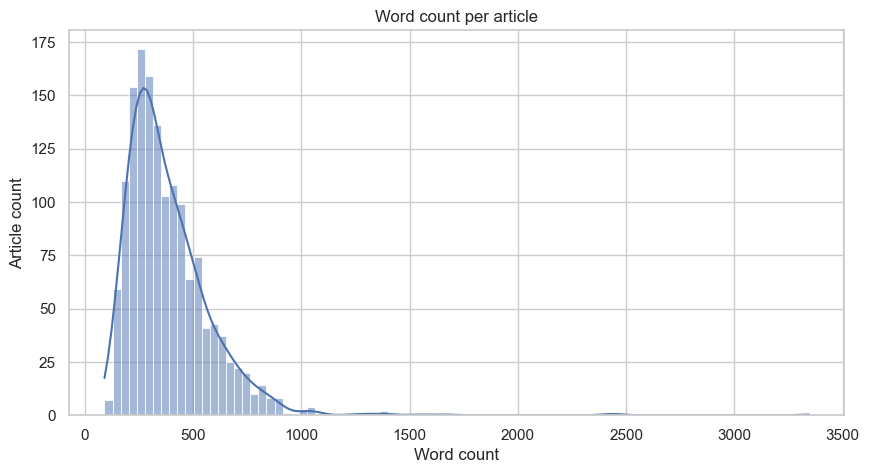

In [703]:
word_count=[]
for i in train["Text"]:
    word_count.append(len(i.split()))

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(word_count, kde=True)
plt.xlabel("Word count")
plt.ylabel("Article count")
plt.title("Word count per article")

Text(0.5, 1.0, 'Word count per Category')

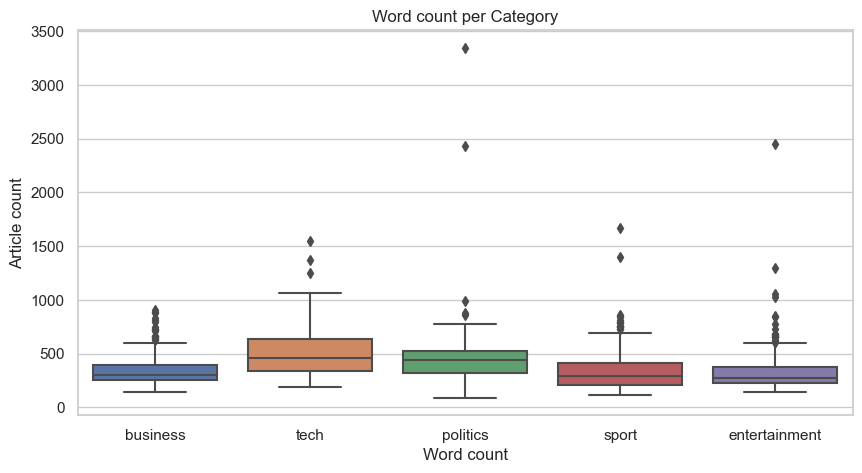

In [704]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(y=word_count, x= train["Category"])
plt.xlabel("Word count")
plt.ylabel("Article count")
plt.title("Word count per Category")

## Data Modelling

#### TF-IDF

The method I will be using to convert raw texts to feature vectors is TF-IDF. TF-IDF measures how of frequent a word occur in a document (TF - term frequency) but infrequent in the corpus (IDF - inverse document frequency), which is more important than those that appear frequent in both the document and the corpus. TF-IDF can be measure using the following:

$w_{x,y}=tf_{x,y} * log(\frac{N}{df_x})$

Where $tf_{x,y}$ measures the frequency of x in document y; $df_x$ measures the number of documents containing x; and N is the total number of documents. I chose this method as some commonly used stop words in english often appear in texts. Hence, taking the inverse document frequency can help minimize the weight of these stop words which allowing infrequent terms weight more.

In [705]:
X_train, X_test, y_train, y_test = train_test_split(train["Text"].to_numpy(), 
                                                    train["Category"].to_numpy(), 
                                                    shuffle = True, test_size=0.20, random_state=42)

I will remove stop words using build-in function stop_words='english' in TfidfVactorizer, some stop words example include “a”, “the”, “is”, “are" and ect. These stop words are commonly used in the English language that provides little to no useful information in regard to labelling topics.

In [706]:
vec = TfidfVectorizer(max_df=0.95, 
                      min_df=2,
                      max_features=10000,
                      stop_words='english',
                      lowercase=True)
tfidf_vec= vec.fit_transform(X_train)
words = vec.get_feature_names()

#### Non-negative matrix factorization

NMF is used to decompose higher-dimensional vectors into lower-dimensional representations. In this project, the document-term matrix is decompose into two smaller matrices - the document-topic and topic-term matrices.

In [707]:
nmf = NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 42)
W = nmf.fit_transform(tfidf_vec)
H = nmf.components_

In [708]:
for i, topic in enumerate(H):
    top_word_idx=topic.argsort()[:-11:-1]
    top_10=[words[i] for i in top_word_idx]
    print (f"Topic {i}:", top_10)

Topic 0: ['england', 'game', 'said', 'win', 'cup', 'world', 'match', 'injury', 'chelsea', 'team']
Topic 1: ['mr', 'said', 'labour', 'election', 'blair', 'government', 'party', 'brown', 'minister', 'people']
Topic 2: ['mobile', 'people', 'said', 'phone', 'software', 'technology', 'users', 'digital', 'games', 'net']
Topic 3: ['film', 'best', 'awards', 'band', 'award', 'actor', 'music', 'star', 'said', 'festival']
Topic 4: ['said', 'growth', 'economy', 'firm', 'bank', 'market', 'company', 'year', 'shares', 'oil']


In [709]:
#remove the word 'said' as it appears in every topic, and label the topic.
top_keywords = {
    'tech': ['mobile', 'people', 'phone', 'software', 'technology', 'users', 'digital', 'games', 'net'],
    'sport': ['england', 'game', 'win', 'cup', 'world', 'match', 'injury', 'chelsea', 'team'],
    'business':['growth', 'economy', 'firm', 'bank', 'market', 'company', 'year', 'shares', 'oil'],
    'politics':  ['mr', 'labour', 'election', 'blair', 'government', 'party', 'brown', 'minister', 'people'],
    'entertainment': ['film', 'best', 'awards', 'band', 'award', 'actor', 'music', 'star', 'festival']
}

# Define the function to label topics
def label_topics(model, topic_names, top_keywords, no_top_words):
    result = {}
    for topic_ind, topic in enumerate(model.components_):
        top_word_ind=topic.argsort()[:-no_top_words-1:-1]
        top_words = [topic_names[i] for i in top_word_ind]
        topic_categories = []
        for category, keywords in top_keywords.items():
            if sum([word in top_words for word in keywords]) >= 3:
                topic_categories.append(category)
        if topic_categories:
            result[topic_ind] = ', '.join(topic_categories)
    return result

# Call the function to label topics
labels= label_topics(nmf, words, top_keywords, 10)

# Print the labeled topics
print(labels)

{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}


In [710]:
model=[]
train_acc=[]
test_acc=[]

top_ind=W.argmax(axis=1)
y_pred=pd.DataFrame(y_train, columns=["Category"])
y_pred["Pred"]=top_ind
y_pred["Pred"]=y_pred["Pred"].replace(labels)

y_pred.head(10)

,Category,Pred
0,sport,sport
1,business,business
2,politics,politics
3,sport,sport
4,politics,politics
5,business,business
6,business,business
7,entertainment,entertainment
8,business,business
9,entertainment,entertainment


In [711]:
nmf_train_acc=accuracy_score(y_pred["Category"], y_pred["Pred"])
model.append("NMF")
train_acc.append(nmf_train_acc)
print("Accuracy score for training data: ", nmf_train_acc)

Accuracy score for training data:  0.9563758389261745


Text(17.25, 0.5, 'Actuals')

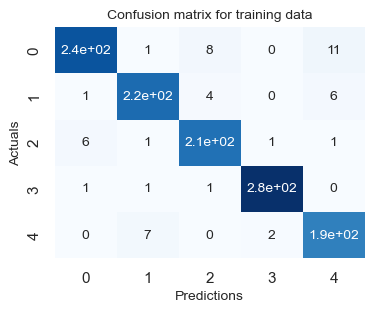

In [712]:
cm=confusion_matrix(y_pred["Category"],y_pred["Pred"])
plt.figure (figsize = [4,3])
plt.title("Confusion matrix for training data", fontsize = 10)
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={"size": 10})
plt.xlabel('Predictions', fontsize = 10)
plt.ylabel('Actuals', fontsize = 10)

In [713]:
print(classification_report(y_pred["Category"],y_pred["Pred"]))

               precision    recall  f1-score   support

     business       0.97      0.92      0.95       261
entertainment       0.96      0.95      0.95       227
     politics       0.94      0.96      0.95       218
        sport       0.99      0.99      0.99       283
         tech       0.92      0.96      0.93       203

     accuracy                           0.96      1192
    macro avg       0.95      0.96      0.95      1192
 weighted avg       0.96      0.96      0.96      1192



In [714]:
test_vec= vec.fit_transform(X_test)
test_words = np.array(vec.get_feature_names())

test_W = nmf.fit_transform(test_vec)
test_H = nmf.components_

test_labels= label_topics(nmf, test_words, top_keywords, no_top_words=10)
test_pred = pd.DataFrame(test_W.argmax(axis=1), columns = ['Category'])
test_pred['Category'] = test_pred['Category'].replace(test_labels)
test_pred['Labels']= y_test

test_pred.head(10)

,Category,Labels
0,tech,entertainment
1,politics,politics
2,politics,politics
3,politics,tech
4,tech,tech
5,business,business
6,tech,tech
7,entertainment,entertainment
8,business,business
9,tech,tech


In [715]:
y_pred=pd.DataFrame(test_pred['Labels'])
test_y=pd.DataFrame(test_pred['Category'])
nmf_test_acc=accuracy_score(test_y, y_pred)
test_acc.append(nmf_test_acc)
print("Accuracy score for testing data: ", nmf_test_acc)

Accuracy score for testing data:  0.9630872483221476


Text(17.25, 0.5, 'Actuals')

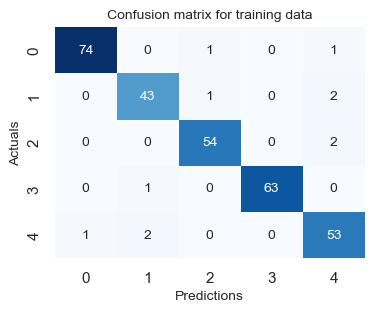

In [716]:
cm=confusion_matrix(test_y,y_pred)
plt.figure (figsize = [4,3])
plt.title("Confusion matrix for training data", fontsize = 10)
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={"size": 10})
plt.xlabel('Predictions', fontsize = 10)
plt.ylabel('Actuals', fontsize = 10)

In [717]:
print(classification_report(test_y,y_pred))

               precision    recall  f1-score   support

     business       0.99      0.97      0.98        76
entertainment       0.93      0.93      0.93        46
     politics       0.96      0.96      0.96        56
        sport       1.00      0.98      0.99        64
         tech       0.91      0.95      0.93        56

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



In [718]:
subset_sizes = [100,200,500,1000]
num_repeats = 5
results = []

for subset_size in subset_sizes:
    for i in range(num_repeats):
        subset_indices = np.random.choice(X_train.shape[0], size=subset_size, replace=False)
        X_subset, y_subset = X_train[subset_indices], y_train[subset_indices]
        nmf_temp=NMF(n_components=5, 
                init='nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler',
                l1_ratio = 0.5,
                random_state = 42)
        W_temp=nmf_temp.fit_transform(tfidf_vec)
        labels= label_topics(nmf_temp, words, top_keywords, 10)
        top_ind=W_temp.argmax(axis=1)
        y_pred=pd.DataFrame(y_train, columns=["Category"])
        y_pred["Pred"]=top_ind
        y_pred["Pred"]=y_pred["Pred"].replace(labels)
        accuracy = accuracy_score(y_pred["Category"], y_pred["Pred"])

        results.append({'subset_size': subset_size, 'repeat': i, 'accuracy': accuracy})

for result in results:
    print(f"Subset size: {result['subset_size']}, Repeat: {result['repeat']}, Accuracy: {result['accuracy']}")

Subset size: 100, Repeat: 0, Accuracy: 0.9563758389261745
Subset size: 100, Repeat: 1, Accuracy: 0.9563758389261745
Subset size: 100, Repeat: 2, Accuracy: 0.9563758389261745
Subset size: 100, Repeat: 3, Accuracy: 0.9563758389261745
Subset size: 100, Repeat: 4, Accuracy: 0.9563758389261745
Subset size: 200, Repeat: 0, Accuracy: 0.9563758389261745
Subset size: 200, Repeat: 1, Accuracy: 0.9563758389261745
Subset size: 200, Repeat: 2, Accuracy: 0.9563758389261745
Subset size: 200, Repeat: 3, Accuracy: 0.9563758389261745
Subset size: 200, Repeat: 4, Accuracy: 0.9563758389261745
Subset size: 500, Repeat: 0, Accuracy: 0.9563758389261745
Subset size: 500, Repeat: 1, Accuracy: 0.9563758389261745
Subset size: 500, Repeat: 2, Accuracy: 0.9563758389261745
Subset size: 500, Repeat: 3, Accuracy: 0.9563758389261745
Subset size: 500, Repeat: 4, Accuracy: 0.9563758389261745
Subset size: 1000, Repeat: 0, Accuracy: 0.9563758389261745
Subset size: 1000, Repeat: 1, Accuracy: 0.9563758389261745
Subset size:

To further validify the model, we make random subset and repeat 5 times for each subset. The accuracy score is still at around 0.956. Hence, this model is reliable.

#### Supervised Learning

In [677]:
vec = TfidfVectorizer(max_df=0.95,
                       min_df=2,
                       stop_words = 'english',
                       lowercase=True,
                       max_features = 5000).fit(X_train)

In [678]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(vec.transform(X_train), y_train)
rf_y_pred=rf.predict(vec.transform(y_train))
rf_y_pred_test=rf.predict(vec.transform(y_test))
rf_train_acc= accuracy_score(y_train, rf_y_pred)
rf_test_acc= accuracy_score(y_test, rf_y_pred_test)
print("Accuracy score for training data using random forest model is: ", rf_train_acc)
print("Accuracy score for testing data using random forest model is: ", rf_test_acc)

model.append('RF')
train_acc.append(rf_train_acc)
test_acc.append(rf_test_acc)

Accuracy score for training data using random forest model is:  0.6468120805369127
Accuracy score for testing data using random forest model is:  0.6174496644295302


In [679]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(vec.transform(X_train), y_train)
svc_y_pred=svc.predict(vec.transform(y_train))
svc_y_pred_test=svc.predict(vec.transform(y_test))
svc_train_acc= accuracy_score(y_train, svc_y_pred)
svc_test_acc= accuracy_score(y_test, svc_y_pred_test)
print("Accuracy score for training data using svc model is: ", svc_train_acc)
print("Accuracy score for testing data using svc model is: ", svc_test_acc)

model.append('SVC')
train_acc.append(svc_train_acc)
test_acc.append(svc_test_acc)

Accuracy score for training data using svc model is:  0.6468120805369127
Accuracy score for testing data using svc model is:  0.6174496644295302


In [680]:
compare_models = pd.DataFrame({'Model': model, 'Training accuracy': train_acc, 'Test accuracy': test_acc})
compare_models

,Model,Training accuracy,Test accuracy
0,NMF,0.956376,0.963087
1,RF,0.646812,0.617450
2,SVC,0.646812,0.617450


Since the dataset is labeled, supervised learning usually produces better accuracy than unsupervised learning method. However, it is not the case for this project, NMF produce much better result than supervised learning models. Overfitting does  seem to be a problem for supervised learning methods as they produces lower accuracy score for their testing data than training.

### Hyperparameter Tuning

In [687]:
init = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
beta_loss= ['frobenius', 'kullback-leibler']
l1_ratio = np.arange(0 , 1 , 0.1)
acc=[]
best_acc = 0
best_params = {}
for ratio in l1_ratio:
    for b in beta_loss:
        for i in init:
            nmf_temp=NMF(n_components=5, 
                    init=i, 
                    solver = 'mu',
                    beta_loss = b,
                    l1_ratio = ratio,
                    random_state = 42)
            W_temp=nmf_temp.fit_transform(tfidf_vec)
            labels= label_topics(nmf_temp, words, top_keywords, 10)
            top_ind=W_temp.argmax(axis=1)
            y_pred=pd.DataFrame(y_train, columns=["Category"])
            y_pred["Pred"]=top_ind
            y_pred["Pred"]=y_pred["Pred"].replace(labels)
            acc_score = accuracy_score(y_pred["Category"], y_pred["Pred"])
            acc.append(acc_score)

            if acc_score > best_acc:
                best_acc = acc_score
                best_params = {"ratio": ratio, "solver": s, "beta_loss": b, "init": i}

print("Best hyperparameters:", best_params)
print("Best accuracy:", best_acc)

Best hyperparameters: {'ratio': 0.0, 'solver': 'cd', 'beta_loss': 'kullback-leibler', 'init': 'nndsvdar'}
Best accuracy: 0.9572147651006712


By tuning the hyperparameters, the best hyperparameters that yields the highest accuracy is shown above.

#### Test data

In [ ]:
sub_vec= vec.fit_transform(test['Text'])
sub_words = np.array(vec.get_feature_names())

sub_W = nmf.fit_transform(sub_vec)
sub_H = nmf.components_
sub_pred = nmf.transform(sub_vec)

sub_labels= label_topics(nmf, sub_words, top_keywords, no_top_words=10)
sub_pred = pd.DataFrame(sub_pred.argmax(axis=1), columns = ['Category'])
sub_pred['Category'] = sub_pred['Category'].replace(sub_labels)

In [ ]:
result = pd.DataFrame(test["ArticleId"]).join(sub_test)
result

score on Kaggle = 0.95646

## Conclusion

The NMF model was used to train the dataset and predict the category for testing data, resulting in an accuracy score of 0.95646. However, to further improve the accuracy of the model, it is recommended to have some human intervention and manually review each text that was inaccurately labeled to understand the reasons for such mistakes.

Based on the classification report, the 'sport' category has the highest precision, recall, and F1 score, while the other categories score slightly lower. This could be due to the fact that they may have more overlapping words with each other than they do with the 'sport' category, which makes it difficult for the model to distinguish between them accurately. Therefore, it may be useful to consider refining the input features or increasing the number of categories to achieve better performance for these categories.

https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8  
https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
https://python.plainenglish.io/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb